<a href="https://colab.research.google.com/github/KHTee/zhusuan/blob/master/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/zhusuan')
import zhusuan as zs

import os
import time
import numpy as np
import six
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

sys.path.append('//content/drive/MyDrive/Colab Notebooks/zhusuan/examples')
import conf
from utils import save_image_collections

Using TensorFlow backend.


In [3]:
@zs.meta_bayesian_net(scope="gen", reuse_variables=True)
def build_gen(y, x_dim, z_dim, y_dim, n):
    bn = zs.BayesianNet()
    z_mean = tf.zeros([n, z_dim])
    z = bn.normal("z", z_mean, std=1., group_ndims=1)
    
    # Concatenate z and y
    z = tf.concat(axis=1, values=[z,y])

    # x_logits = f_NN(z)
    h = tf.layers.dense(z, 500, activation=tf.nn.relu)
    h = tf.layers.dense(h, 500, activation=tf.nn.relu)
    x_logits = tf.layers.dense(h, x_dim)
    bn.deterministic("x_mean", tf.sigmoid(x_logits))

    # add observation distribution (noise)
    bn.bernoulli("x", x_logits, group_ndims=1, dtype=tf.float32)
    return bn

@zs.reuse_variables(scope="q_net")
def build_q_net(x, y, z_dim, y_dim):
    bn = zs.BayesianNet()
    # concatenate x and y
    x = tf.concat(axis=1, values=[x,y])
    h = tf.layers.dense(x, 500, activation=tf.nn.relu)
    h = tf.layers.dense(h, 500, activation=tf.nn.relu)
    z_mean = tf.layers.dense(h, z_dim)
    z_logstd = tf.layers.dense(h, z_dim)
    bn.normal("z", z_mean, logstd=z_logstd, group_ndims=1)
    return bn

In [4]:
# load train and test data using Keras API.
(x_train, y_train_temp), (x_test, y_test_temp) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],784)/255
x_test = x_test.reshape(x_test.shape[0],784)/255

# draw samples from binomial distribution
x_train = np.random.binomial(1, x_train, size=x_train.shape).astype(np.float32)
x_test = np.random.binomial(1, x_test, size=x_test.shape).astype(np.float32)
x_dim = x_train.shape[1]    

# Convert label into one-hot vector
y_train = to_categorical(np.array(y_train_temp))
y_test = to_categorical(np.array(y_test_temp))
y_dim = y_train.shape[1]

# class vector
input_data = to_categorical(np.arange(10))

# Define model parameters
z_dim = 10

# Build the computation graph
x = tf.placeholder(tf.float32, shape=[None, x_dim], name="x")
y = tf.placeholder(tf.float32, shape=[None, y_dim], name="y")
n = tf.placeholder(tf.int32, shape=[], name="n")

model = build_gen(y, x_dim, z_dim, y_dim, n)
variational = build_q_net(x, y, z_dim, y_dim)

lower_bound = zs.variational.elbo(model, {"x": x}, variational=variational)
cost = tf.reduce_mean(lower_bound.sgvb())
lower_bound = tf.reduce_mean(lower_bound)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
infer_op = optimizer.minimize(cost)

# Random generation
x_gen = tf.reshape(model.observe()["x_mean"], [-1, 28, 28, 1])

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Time taken for 100 epoch: 802.113562948


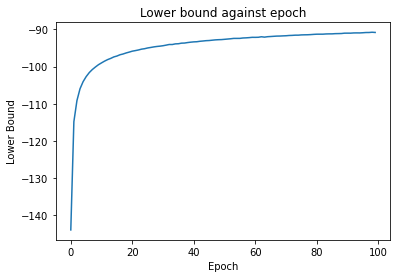

In [5]:
start = time.process_time()
epochs = 100
batch_size = 32
iters = x_train.shape[0] // batch_size

lb_list = []
# Run the Inference
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        time_epoch = -time.time()
        lbs = []
        for t in range(iters):
            x_batch = x_train[t * batch_size:(t + 1) * batch_size]
            y_batch = y_train[t * batch_size:(t + 1) * batch_size]
            _, lb = sess.run([infer_op, lower_bound],
                              feed_dict={x: x_batch,
                                        y: y_batch,
                                        n: batch_size})
            lbs.append(lb)
        time_epoch += time.time()
        mean_lb = np.mean(lbs)
        # print("Epoch {} ({:.1f}s): Lower bound = {}".format(epoch+1, time_epoch, mean_lb))
        lb_list.append(mean_lb)
        
        img = sess.run(x_gen, feed_dict={y: input_data, n: 10})
        name = os.path.join("/content/drive/MyDrive/output_img", "epoch_{}.png".format(epoch+1))
        save_image_collections(img, name, shape=(1, 10))

print('Time taken for 100 epoch: {}'.format(time.process_time() - start))
plt.plot(lb_list)
plt.title('Lower bound against epoch')
plt.xlabel('Epoch')
plt.ylabel('Lower Bound')
plt.savefig(os.path.join("/content/drive/MyDrive/output_img", "lower_bound.png"))